<a href="https://colab.research.google.com/github/Gabriele90/ML-for-the-life-sciences-/blob/main/K_mean_clustering_and_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTRODUCTION

The aim of this exercise is to segment the molecules on their LogP and MW. I used different clustering algorithms for executing a "Molecular segmentation". It consists in dividing molecules based on subgroups that are similar. It is useful in pharmacology analysis.

***Importing libraries and dataset***

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


***Importing the dataset***

In [2]:
df = pd.read_csv("phosphatase3class.csv")
df.head(5)

,Unnamed: 0,molecule_chembl_id,canonical_smiles,Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL265864,COC(=O)c1cc(NC(=O)CCCC(=O)NC2CC(C)(C)N([O])C(C...,inactive,434.513,2.7709,3.0,6.0,3.000000
1,1,CHEMBL389502,CC1(C)CC(NC(=O)/C=C/c2ccc(-c3cccc([N+](=O)[O-]...,inactive,412.466,4.3513,1.0,5.0,3.675718
2,2,CHEMBL445152,CC1(C)CC(NC(=O)CCCC(=O)Nc2ccc(O)c(C(=O)O)c2)CC...,inactive,420.486,2.6825,4.0,5.0,3.000000
3,3,CHEMBL390088,CC1(C)CC(NC(=O)/C=C/c2ccc(-c3ccc([N+](=O)[O-])...,inactive,412.466,4.3513,1.0,5.0,3.000000
4,4,CHEMBL227379,CC1(C)CC(NC(=O)/C=C/c2ccc(-c3ccc(O)c(C(=O)O)c3...,intermediate,427.477,3.8469,3.0,5.0,5.124939


***Data cleaning and feature enginering***

In [3]:
df.drop("molecule_chembl_id", axis = 1, inplace=True)

In [4]:
df.drop("canonical_smiles", axis = 1, inplace=True)

In [5]:
df.drop("Unnamed: 0", axis = 1, inplace=True)

In [6]:
df["Class"].replace("inactive", 0, inplace=True)
df["Class"].replace("active", 1, inplace=True)
df["Class"].replace("intermediate", 2, inplace=True)
df.head(10)

,Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,434.513,2.7709,3.0,6.0,3.000000
1,0,412.466,4.3513,1.0,5.0,3.675718
2,0,420.486,2.6825,4.0,5.0,3.000000
3,0,412.466,4.3513,1.0,5.0,3.000000
4,2,427.477,3.8469,3.0,5.0,5.124939
5,0,387.456,3.8071,3.0,5.0,3.000000
6,0,401.483,3.8955,2.0,6.0,3.000000
7,0,532.556,6.3342,3.0,7.0,4.493495
8,1,612.154,5.8607,1.0,8.0,6.207608
9,1,595.699,5.3464,1.0,8.0,6.060481


Text(0.5, 1.0, 'Bioactivity Class')

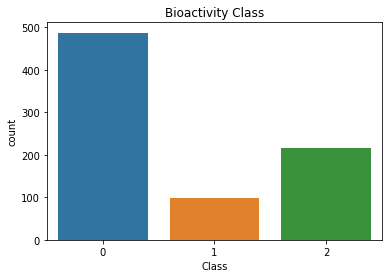

In [7]:
sns.countplot(x='Class', data=df)
plt.title('Bioactivity Class')

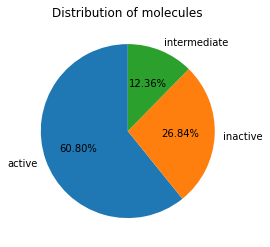

In [8]:
bio_class= df.Class.value_counts()
bio_class_label=['active','inactive','intermediate']
plt.pie(bio_class, labels=bio_class_label, autopct='%0.2f%%',startangle=90)
plt.title('Distribution of molecules')
plt.show()

In [9]:
df.describe()

,Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.660424,377.194076,3.431050,1.483146,5.091136,4.799892
std,0.872951,100.248573,1.659214,0.956571,1.988199,0.899027
min,0.000000,112.128000,-1.816800,0.000000,0.000000,3.000000
25%,0.000000,305.374000,2.397540,1.000000,4.000000,4.000000
50%,0.000000,373.481000,3.356220,1.000000,5.000000,4.322393
75%,2.000000,444.440000,4.440220,2.000000,6.000000,5.554396
max,2.000000,1085.631000,11.793900,9.000000,11.000000,7.841638


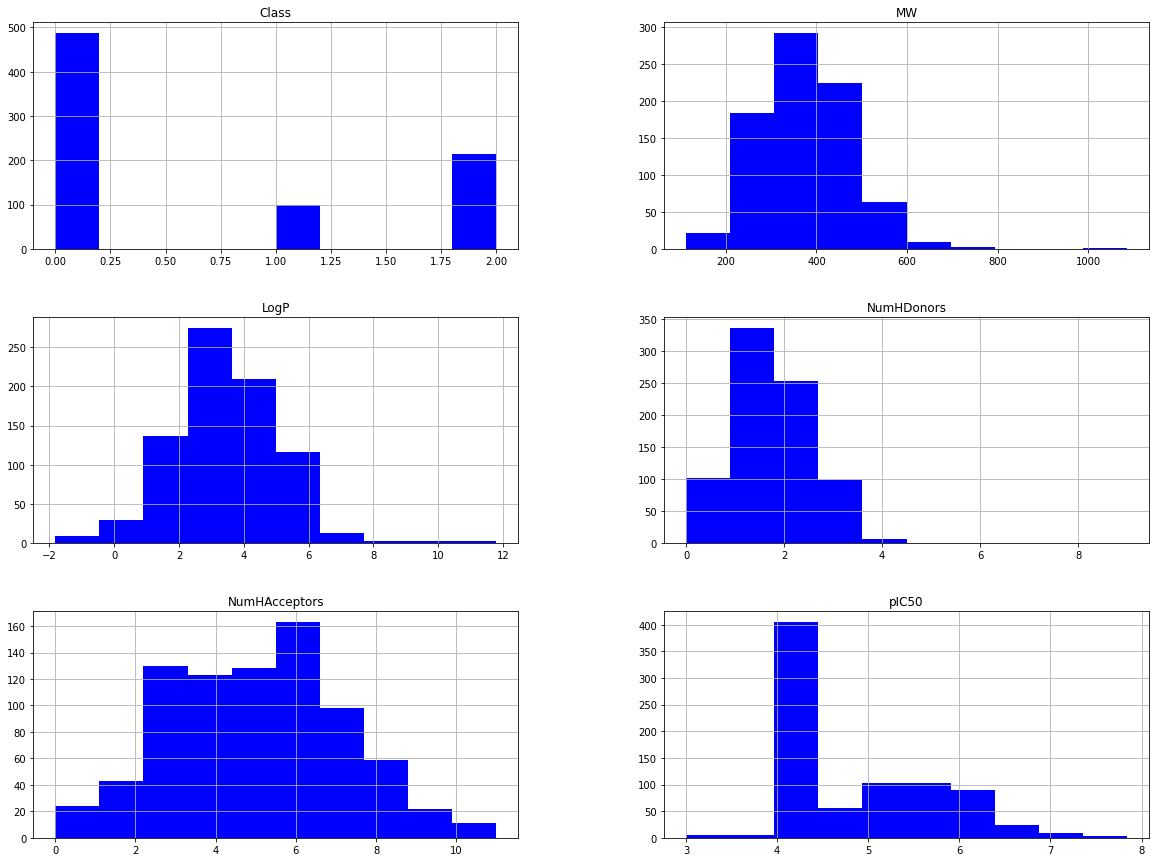

In [10]:
df.hist(color='blue', figsize=(20,15));

In [11]:
mw_zeros = df[df['MW'] == 0].shape[0]
log_zeros = df[df['LogP'] == 0].shape[0]
hdon_zeros = df[df['NumHDonors'] == 0].shape[0]
hacc_zeros = df[df['NumHAcceptors'] == 0].shape[0]
pIC_zeros = df[df['pIC50'] == 0].shape[0]
print(f"Number of zeros 'MW' column have : {mw_zeros}")
print(f"Number of zeros 'LogP' column have : {log_zeros}")
print(f"Number of zeros 'NumHDonors' column have : {hdon_zeros}")
print(f"Number of zeros 'NumHAcceptors' column have : {hacc_zeros}")
print(f"Number of zeros 'pIC50' column have : {pIC_zeros}")

Number of zeros 'MW' column have : 0
Number of zeros 'LogP' column have : 0
Number of zeros 'NumHDonors' column have : 102
Number of zeros 'NumHAcceptors' column have : 1
Number of zeros 'pIC50' column have : 0


In [12]:
df2 =df.copy()

In [13]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Class,801.0,0.660424,0.872951,0.0000,0.00000,0.000000,2.000000,2.000000
MW,801.0,377.194076,100.248573,112.1280,305.37400,373.481000,444.440000,1085.631000
LogP,801.0,3.431050,1.659214,-1.8168,2.39754,3.356220,4.440220,11.793900
NumHDonors,801.0,1.483146,0.956571,0.0000,1.00000,1.000000,2.000000,9.000000
NumHAcceptors,801.0,5.091136,1.988199,0.0000,4.00000,5.000000,6.000000,11.000000
pIC50,801.0,4.799892,0.899027,3.0000,4.00000,4.322393,5.554396,7.841638


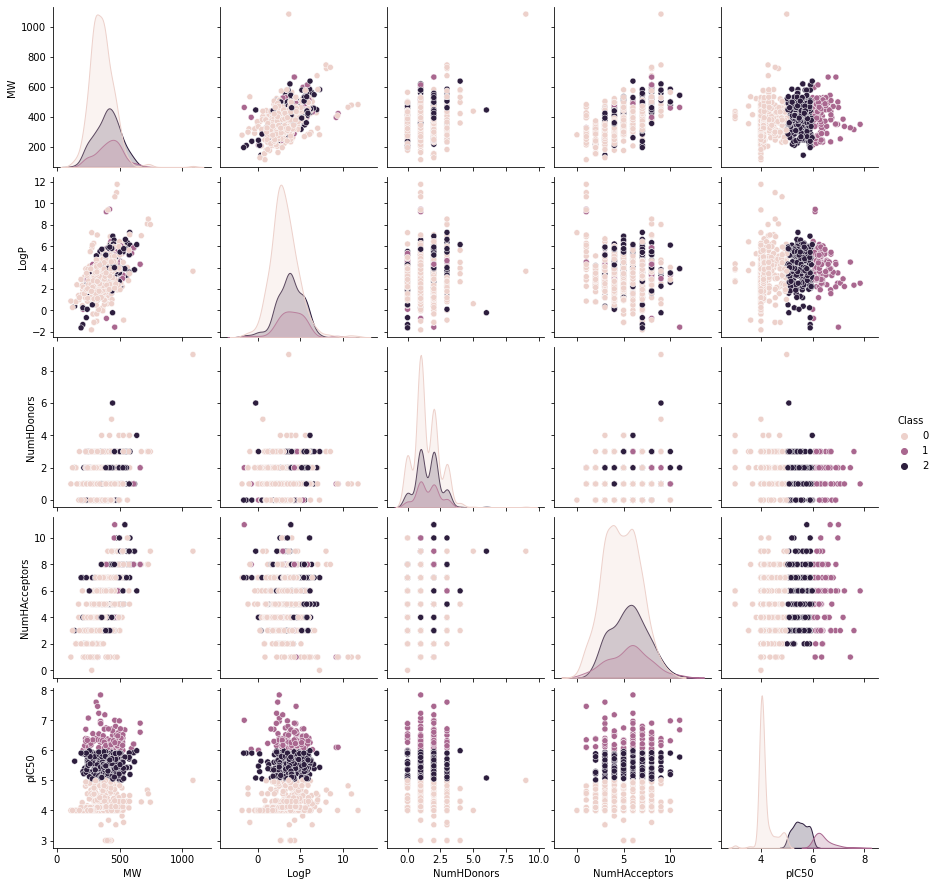

In [14]:
import seaborn as sns
sns.pairplot(data = df2, hue = 'Class');

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

***K-mean clustering***

Lets apply k-means on our dataset, and take look at cluster labels.

The KMeans class has many parameters that can be used, but we will be using these three:

init: Initialization method of the centroids.
Value will be: "k-means++"

k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.

n_clusters: The number of clusters to form as well as the number of centroids to generate.

Value will be: 5 (we can change this anytime if we want to test more values)

n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

Value will be: automatic but can be chosen if needed

Let's initialize KMeans with these parameters, where the output parameter is called k_means.

In [16]:
import numpy as np
from numpy.linalg import norm


class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
    
    def predict(self, X):
        distance = self.compute_distance(X, old_centroids)
        return self.find_closest_cluster(distance)

We are interested in MW and LOgP, so we drop the other features. Then we SCALE the features value.

In [17]:
df_mw_log=df2.drop(["pIC50", "NumHDonors", "NumHAcceptors", "Class"], axis = 1)

In [18]:
X_std = StandardScaler().fit_transform(df_mw_log)

*Plotting the clustering*

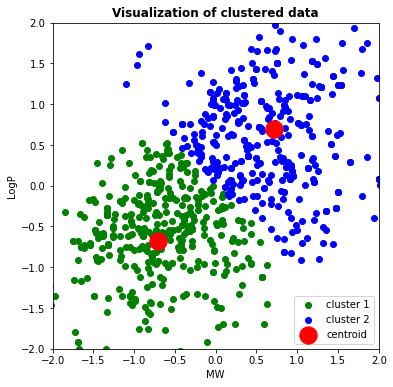

In [19]:

# Run local implementation of kmeans
km = Kmeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.centroids

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('MW')
plt.ylabel('LogP')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

Alternative code to cluster the data into five clusters

Text(0, 0.5, 'LogP')

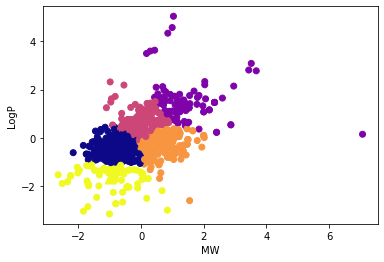

In [20]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_std)
y_pred = kmeans.predict(X_std)
# plot the cluster assignments and cluster centers
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_pred, cmap="plasma")
plt.scatter(kmeans.cluster_centers_[:, 0],   
            kmeans.cluster_centers_[:, 1],
            marker='^', 
            c=[0, 1, 2, 3, 4], 
            s=100, 
            linewidth=2,
            cmap="plasma")
plt.xlabel("MW")
plt.ylabel("LogP")

**3D Plot**

We will use three dimensions for this analysis and visualise results in a 3D graph. We will have an interactive 3D graph to help with visualisation.

In [21]:
from matplotlib import interactive
interactive(True)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [22]:
k_means_3D=KMeans(n_clusters=2)
k_means_3D.fit(df_mw_log)
labels = k_means_3D.labels_
centers_3D=k_means_3D.cluster_centers_

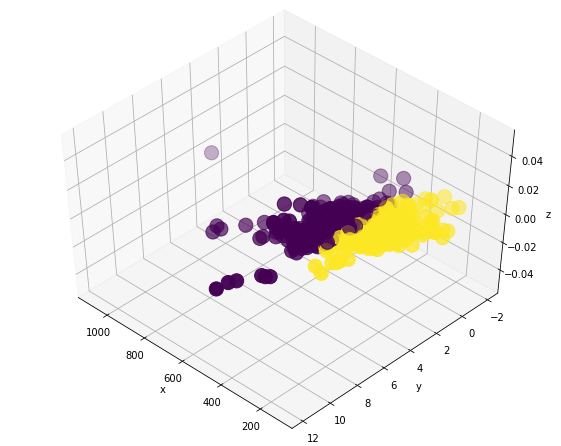

In [23]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(df_mw_log['MW'], df_mw_log['LogP'], c= labels.astype(np.float), s=200)

***Random Initialization***

We’ll show that different initializations of centroids may yield to different results. I’ll use 9 different random_state to change the initialization of the centroids and plot the results. The title of each plot will be the sum of squared distance of each initialization.

As a side note, this dataset is considered very easy and converges in less than 10 iterations. Therefore, to see the effect of random initialization on convergence, I am going to go with 3 iterations to illustrate the concept. However, in real world applications, datasets are not at all that clean and nice!

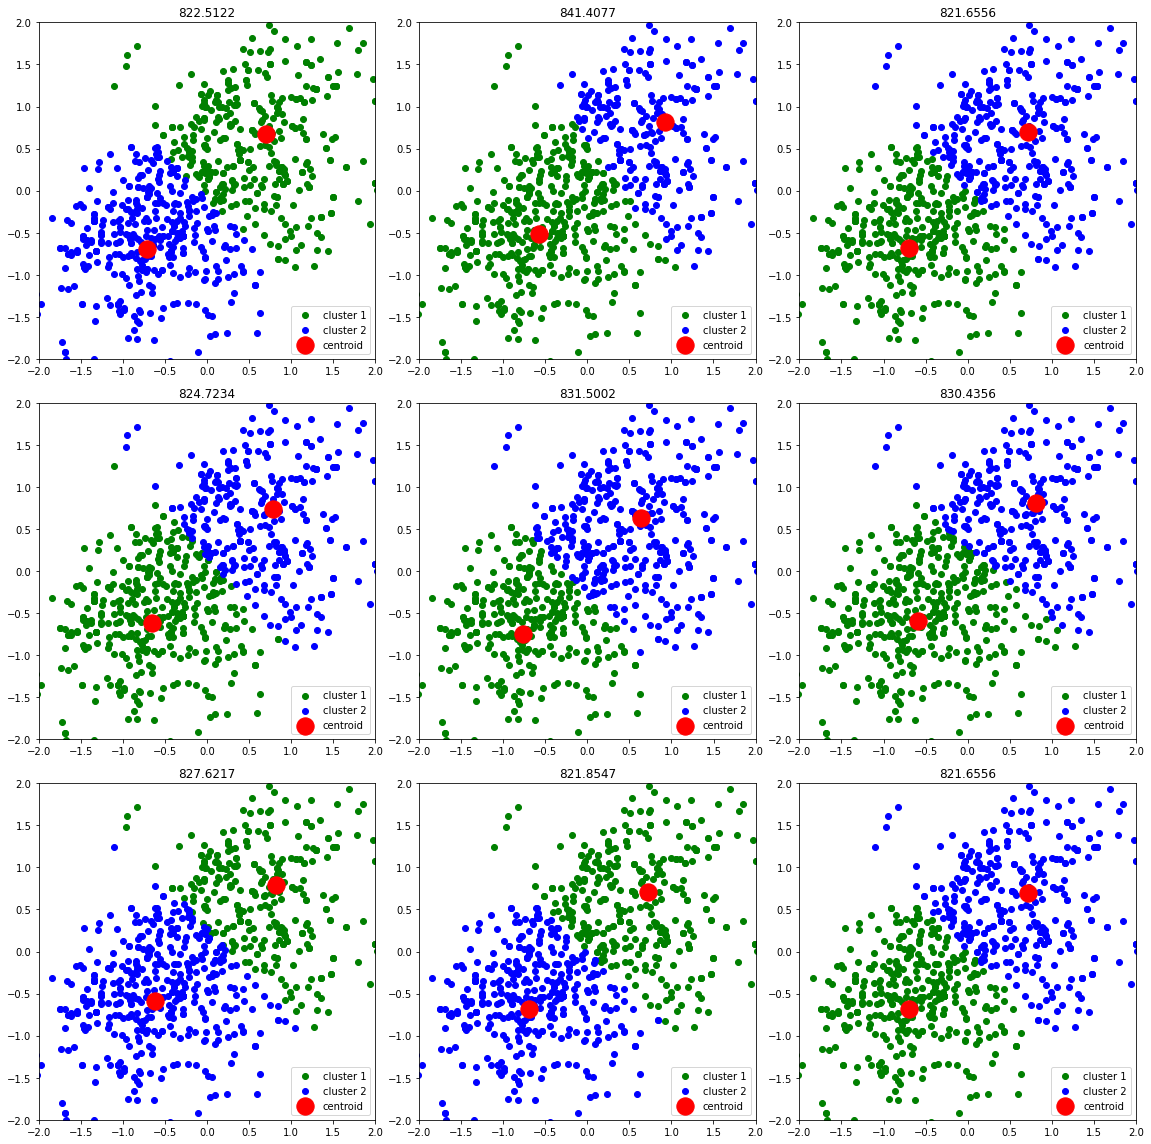

In [24]:
n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='o', s=300, label='centroid')
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout();

As the graph above shows that we only ended up with two different ways of clusterings based on different initializations. We would pick the one with the lowest sum of squared distance.

***Evaluation Methods***

Contrary to supervised learning where we have the ground truth to evaluate the model’s performance, clustering analysis doesn’t have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Moreover, since kmeans requires k as an input and doesn’t learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem. 

***Elbow Method***

Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where SSE starts to flatten out and forming an elbow. We’ll use the geyser dataset and evaluate SSE for different values of k and see where the curve might form an elbow and flatten out.

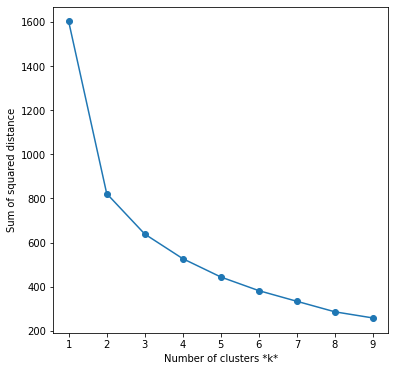

In [25]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

The graph above shows that k=2 is the best choice. Sometimes it’s still hard to figure out a good number of clusters to use because the curve is monotonically decreasing and may not show any elbow or has an obvious point where the curve starts flattening out.

***Silhouette Analysis***

Silhouette analysis can be used to determine the degree of separation between clusters. Therefore, we want the coefficients to be as big as possible and close to 1 to have a good clusters. We’ll use here geyser dataset again because its cheaper to run the silhouette analysis and it is actually obvious that there is most likely only two groups of data points.

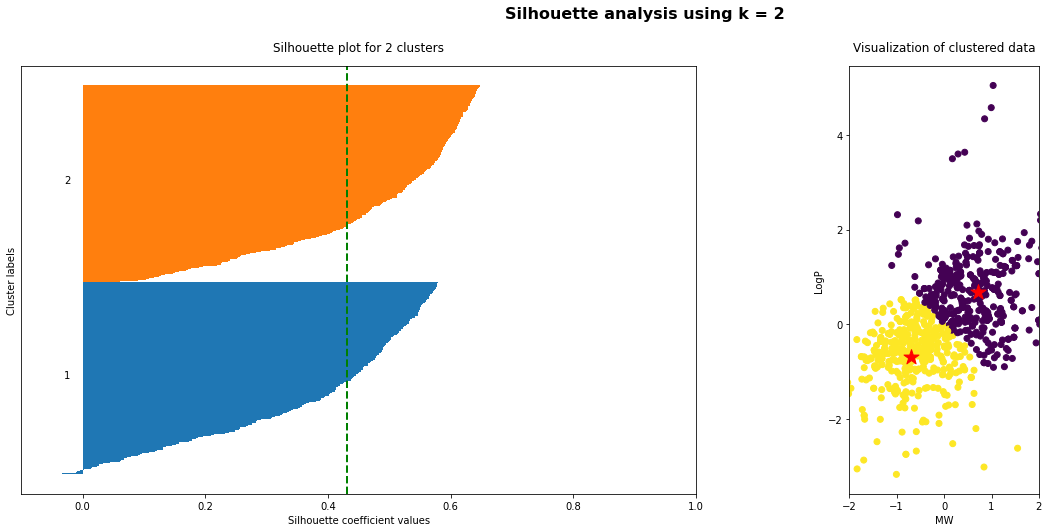

In [26]:
for i, k in enumerate([2]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for 2 clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('MW')
    ax2.set_ylabel('LogP')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [27]:
sil_avg_score_2 = avg_score

print("The average silhouette score using 2 clusters is = ", sil_avg_score_2)

The average silhouette score using 2 clusters is =  0.4310382423457795


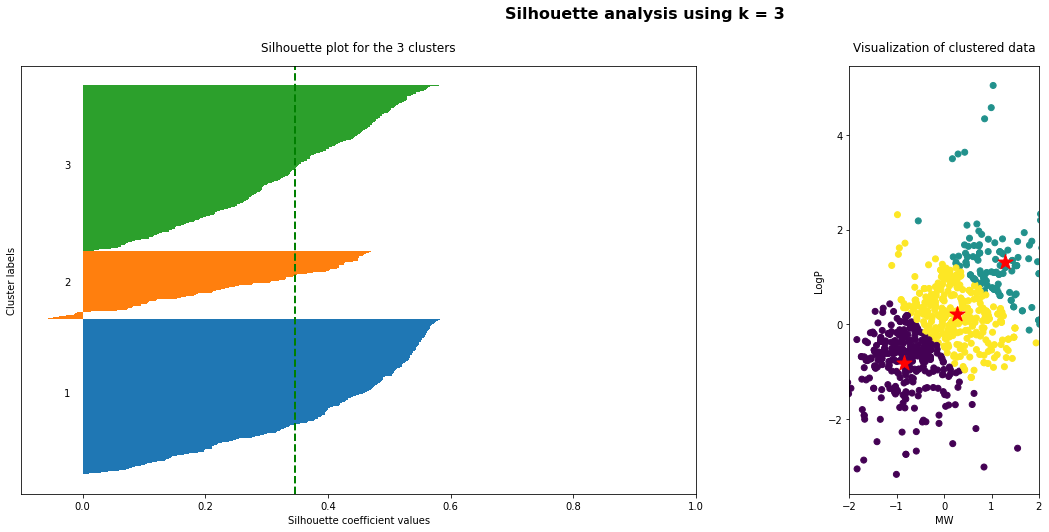

In [28]:
for i, k in enumerate([3]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the 3 clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('MW')
    ax2.set_ylabel('LogP')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [29]:
sil_avg_score_3 = avg_score

print("The average silhouette score using 3 clusters is = ", sil_avg_score_3)

The average silhouette score using 3 clusters is =  0.34603431913640853


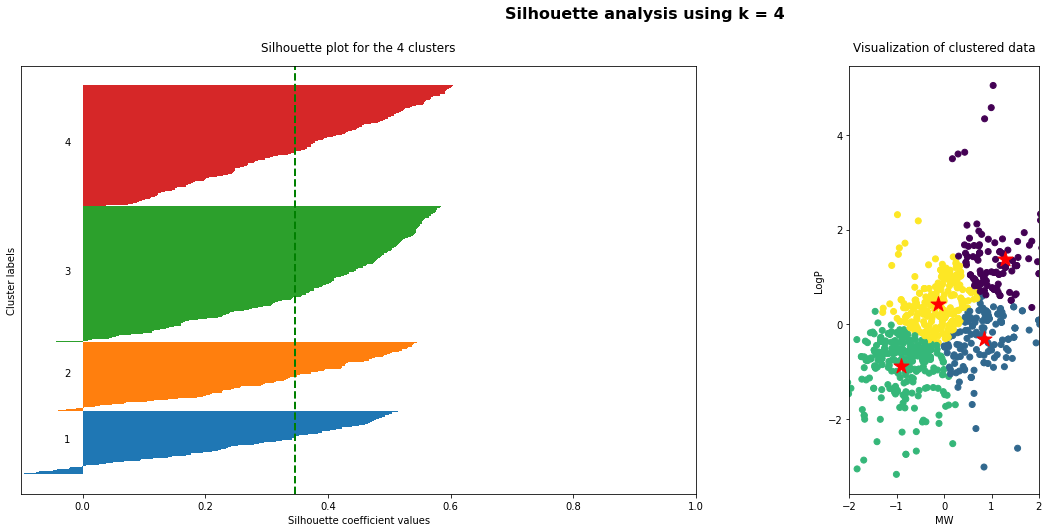

In [30]:
for i, k in enumerate([4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the 4 clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('MW')
    ax2.set_ylabel('LogP')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [31]:
sil_avg_score_4 = avg_score

print("The average silhouette score using 4 clusters is = ", sil_avg_score_4)

The average silhouette score using 4 clusters is =  0.3470060080964123


In [32]:
print("The average silhouette score using 2 clusters is = ", sil_avg_score_2)
print("The average silhouette score using 3 clusters is = ", sil_avg_score_3)
print("The average silhouette score using 4 clusters is = ", sil_avg_score_4)

The average silhouette score using 2 clusters is =  0.4310382423457795
The average silhouette score using 3 clusters is =  0.34603431913640853
The average silhouette score using 4 clusters is =  0.3470060080964123


As the above plots show, n_clusters=2 has the best average silhouette score of around 0.43 and all clusters being above the average shows that it is actually a good choice. Also, the thickness of the silhouette plot gives an indication of how big each cluster is. The plot shows that cluster 1 has almost double the samples than cluster 2. However, as we increased n_clusters to 3 and 4, the average silhouette score decreased dramatically to around 0.35. 

***Visualise the bioactivity class distribution in this clustering.***

However, we might be interested to see if gender plays a role in this classification. We will therefore color some blobs by bioactivity class.

In [33]:
k_means_income=KMeans(n_clusters=2)
k_means_income.fit(df_mw_log)
labels = k_means_income.labels_


In [34]:
centers_income=k_means_income.cluster_centers_
centers_income

array([[305.39786301,   2.74729413],
       [463.82421763,   4.25607832]])

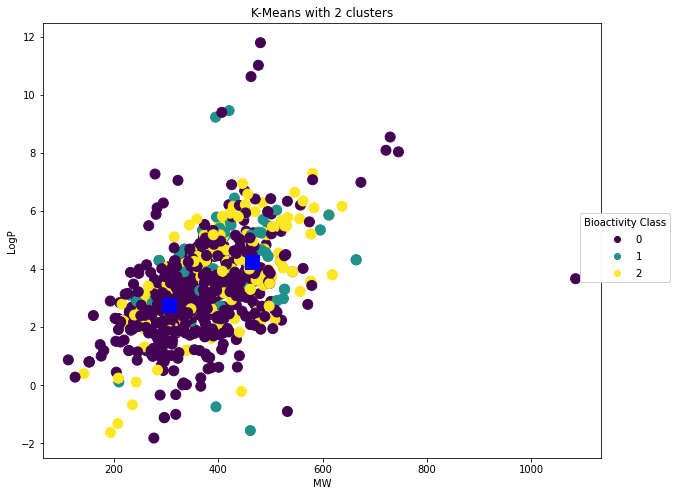

In [35]:
ax=plt.figure(figsize=(10, 8))

scatter=plt.scatter(df_mw_log['MW'], 
            df_mw_log['LogP'], 
            c=df2['Class'], s=100)

plt.scatter(centers_income[:,0], centers_income[:,1], color='blue', marker='s', s=200) 

legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Bioactivity Class")
ax.add_artist(legend1)

plt.xlabel('MW')
plt.ylabel('LogP')
plt.title('K-Means with 2 clusters')

plt.show()

***DBSCAN***

DBSCAN is an extremely powerful clustering algorithm. The acronym stands for Density-based Spatial Clustering of Applications with Noise. As the name suggests, the algorithm uses density to gather points in space to form clusters. The algorithm can be very fast once it is properly implemented.

In [36]:
from sklearn.cluster import DBSCAN

The most important parameter of DBSCAN can be identified as eps. It is the furthest distance at which a point will pick its neighbours. Therefore, intuitively this will decide how many neighbours a point will discover. Although for the min_points/min_samples we can give a default value, we cannot do so for eps.

In [37]:
dbscan = DBSCAN(eps=0.123, min_samples = 5)
clusters = dbscan.fit_predict(X_std)

Text(0, 0.5, 'LogP')

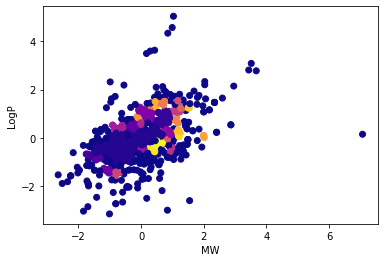

In [38]:
plt.scatter(X_std[:, 0], X_std[:, 1], c=clusters, cmap="plasma")
plt.xlabel("MW")
plt.ylabel("LogP")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


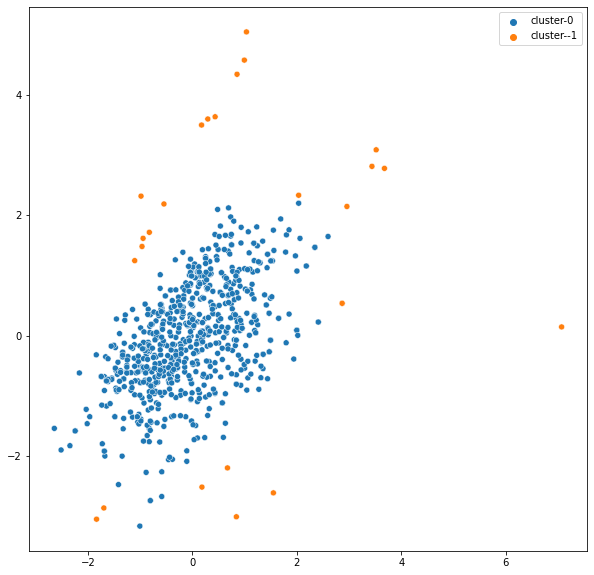

In [39]:
db = DBSCAN(eps=0.5, min_samples=5).fit(X_std)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(X_std[:,0], X_std[:,1], hue=["cluster-{}".format(x) for x in labels])

***Tuning EPS parameter***

We can clearly see from our last figure, two clusters have been merged together. This is bad. Such situations can reduce recall in a real-world clustering application. Let’s try to vary eps and cluster again. 

1.0
0.5
0.3333333333333333
0.25
0.2


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

0.16666666666666666
0.14285714285714285
0.125


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.1111111111111111
0.1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


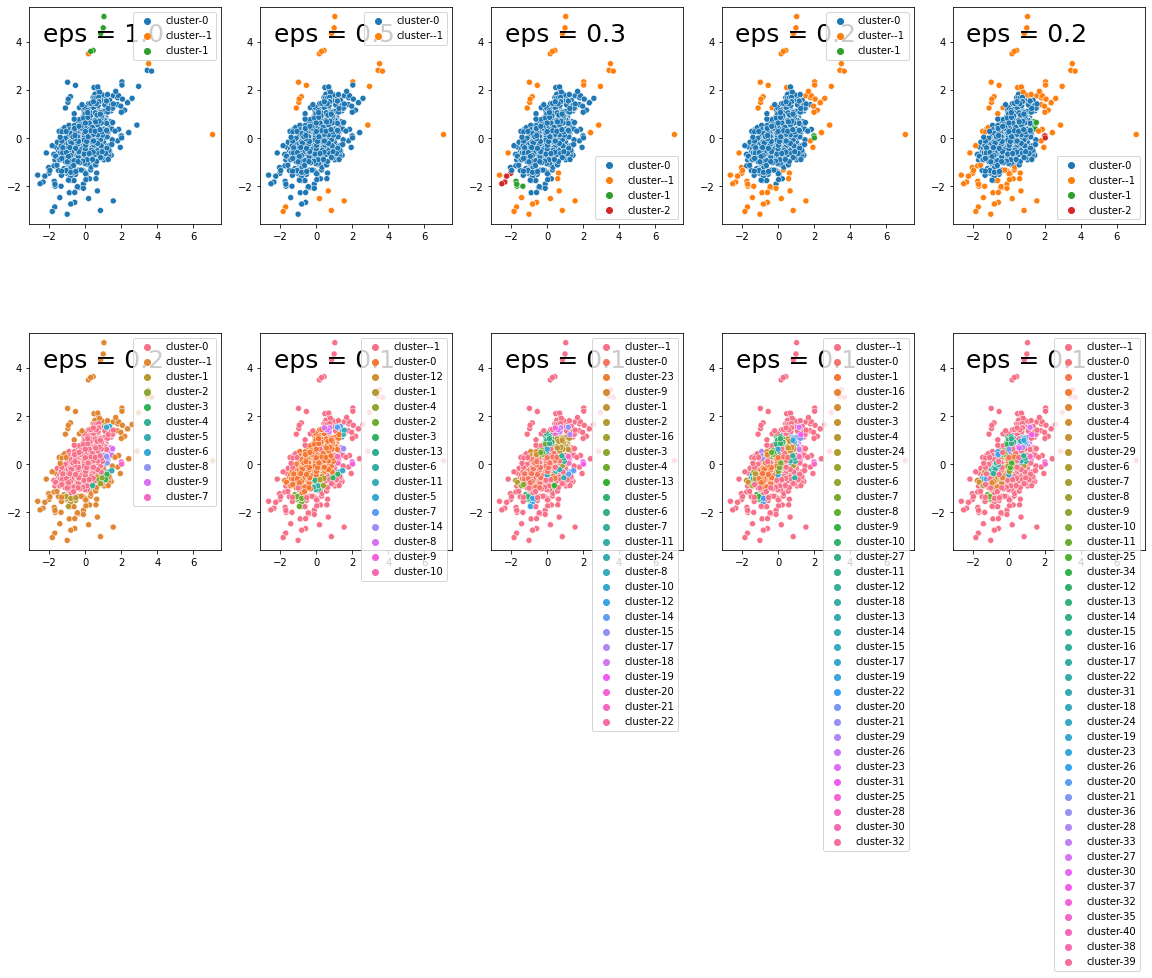

In [40]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=5).fit(X_std)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_std[:,0], X_std[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1

Since the eps figure is proportional to the expected number of neighbours discovered, we can use the nearest neighbours to reach a fair estimation for eps. Let us compute the nearest neighbours.

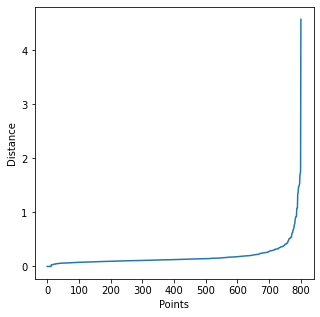

In [41]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_std)
distances, indices = neighbors.kneighbors(X_std)
distances = np.sort(distances[:,5], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

Note that in the nearest neighbour calculation, the point itself will appear as the first nearest neighbour. So we seek the 11 nearest neighbours. We sort the distance to the 10th nearest neighbour and plot the distance variation. As we can see, the elbow point appears somewhere in between 0.1 and 0.3. Quite what we were expecting isn’t it? I choose the 10th neighbour considering the fact that I pick 10 as min_samples value for clustering.

***KneeLocator to Detect Elbow Point***

Now let's detecti the elbow point (or knee point). We can use the following code to find and plot the knee point.

0.2974182932046613


<Figure size 360x360 with 0 Axes>

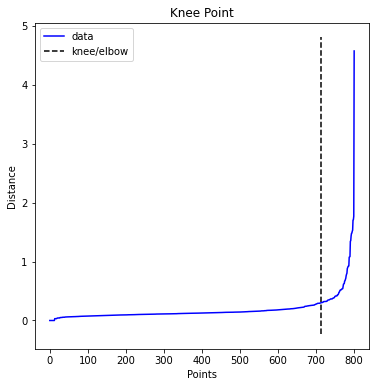

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
! pip install kneed
from kneed import KneeLocator, DataGenerator as dg

i = np.arange(len(distances))
knee = KneeLocator (i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

We can see that the detected knee point by this method is at distance 0.29. Now we can use this value as our eps to see how our new clustering would look like.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


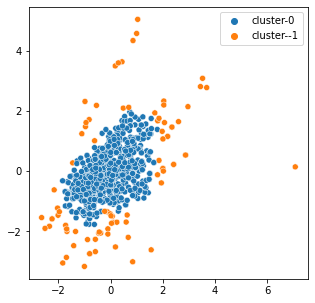

In [43]:
db = DBSCAN(eps=distances[knee.knee], min_samples=10).fit(X_std)
labels = db.labels_
fig = plt.figure(figsize=(5, 5))
sns.scatterplot(X_std[:,0], X_std[:,1], hue=["cluster-{}".format(x) for x in labels])
plt.savefig("dbscan_with_knee.png", dpi=300)

We can see that we have a reasonable estimate of the actual clustering. This is usually good enough for research work. If non-existence of out-liers is an intuitive assumption for the scenario, one can simply use the computed nearest neighbours to re-assign the outlier points (named as cluster--1) to detected clusters.

Now let's evaluate the silhouette score of DBSCAN

In [44]:
score_db = silhouette_score (X_std, db.labels_)

print("The score is = ", score_db)

The score is =  0.41096809188865385


We got a good silhouette score of 0.41.

***Mean Shift Clustering Algorithm***

Mean shift clustering is a sliding-window-based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. These candidate windows are then filtered in a post-processing stage to eliminate near-duplicates, forming the final set of center points and their corresponding groups.

In [45]:
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D

In [46]:
ms = MeanShift()
ms.fit(X_std)
cluster_centers = ms.cluster_centers_

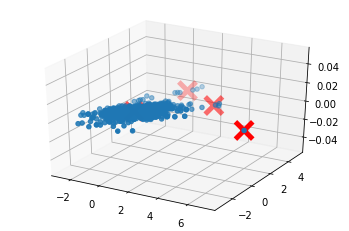

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_std[:,0], X_std[:,1], marker='o')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='red', s=300, linewidth=5, zorder=10)
plt.show()

Now let's evaluate the silhouette score of Mean shift clustering

In [48]:
score_ms = silhouette_score (X_std, ms.labels_)

print("The score is = ", score_ms)

The score is =  0.4382051996290965


We got a good silhouette score of 0.43.

***Hierarchial agglomerative clustering***

Hierarchical clustering algorithms group similar objects into groups called clusters. There are two types of hierarchical clustering algorithms:
Agglomerative — Bottom up approach. Start with many small clusters and merge them together to create bigger clusters.

In [49]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

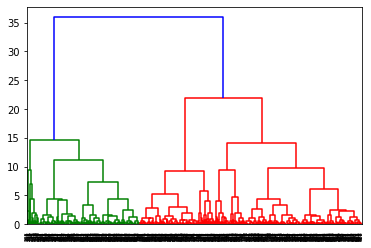

In [50]:
dendrogram = sch.dendrogram(sch.linkage(X_std, method='ward'))

In [51]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X_std)
labels = model.labels_

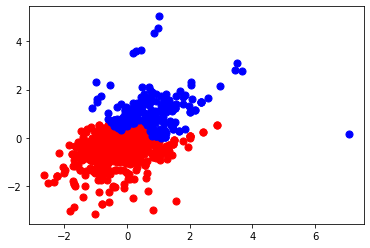

In [52]:
plt.scatter(X_std[labels==0, 0], X_std[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X_std[labels==1, 0], X_std[labels==1, 1], s=50, marker='o', color='blue')

plt.show()

Now let's evaluate the silhouette score of  Hierarchial agglomerative clustering

In [53]:
score_de = silhouette_score (X_std, model.labels_)

print("The silhouette score for HAC using 2 clusters is = ", score_de)

The silhouette score for HAC using 2 clusters is =  0.37228582268859906


We got a score of 0.37.

***Principal Components Analysis (PCA)***

PCA is a well-known unsupervised dimensionality reduction technique that constructs relevant features/variables through linear (linear PCA) or non-linear (kernel PCA) combinations of the original variables (features). In this post, we will only focus on the famous and widely used linear PCA method.

The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs).

In [54]:
from sklearn.decomposition import PCA
plt.style.use('ggplot')

In [55]:
# The PCA model
pca = PCA(n_components=2) # estimate only 2 PCs
df_noclass=df2.drop(["Class"], axis = 1) #let's drop the only features not involved in the process
X_std1 = StandardScaler().fit_transform(df_noclass)
X_pca = pca.fit_transform(X_std1) # project the original data into the PCA space

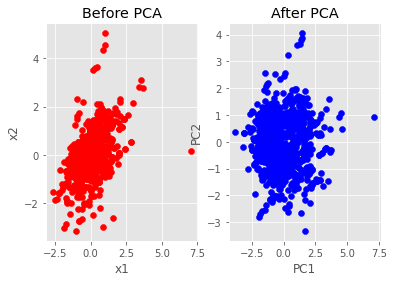

In [56]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X_std1[:,0], X_std1[:,1], c='r')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_pca[:,0], X_pca[:,1], c='b')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [57]:
print(pca.explained_variance_ratio_)

[0.3945563  0.21099163]


***Feature importance***

The importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude — higher importance).

Let’s find the most important features:

In [58]:
print(abs( pca.components_ ))

[[0.66030662 0.42611876 0.17225456 0.47039873 0.36258981]
 [0.06955927 0.59601636 0.3417031  0.70192872 0.174531  ]]


Here, pca.components_ has shape [n_components, n_features] Thus, by looking at the PC1 (first Principal Component) which is the first row we can conclude that **feature 1, 2 and 4 are the most important for PC1. Similarly, we can state that feature 2 and 4 are the most important for PC2.**

***The biplot***

The biplot is the best way to visualize all-in-one following a PCA analysis.

There is an implementation in R but there is no standard implementation in python so I decided to write my own function for that:

In [59]:
def biplot(score, coeff , y):
  xs = score[:,0] # projection on PC1
  ys = score[:,1] # projection on PC2
  n = coeff.shape[0] # number of variables
  plt.figure(figsize=(10,8), dpi=100)
  classes = np.unique(y)
  colors = ['g','r','y']
  markers=['o','^','x']
  for s,l in enumerate(classes):
    plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):#plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
      plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'y', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=1)
      plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center',fontsize=8)
      plt.xlabel("PC{}".format(1), size=14)
      plt.ylabel("PC{}".format(2), size=14)
      limx= int(xs.max()) + 1
      limy= int(ys.max()) + 1
      plt.xlim([-limx,limx])
      plt.ylim([-limy,limy])
      plt.grid()
      plt.tick_params(axis='both', which='both', labelsize=14)

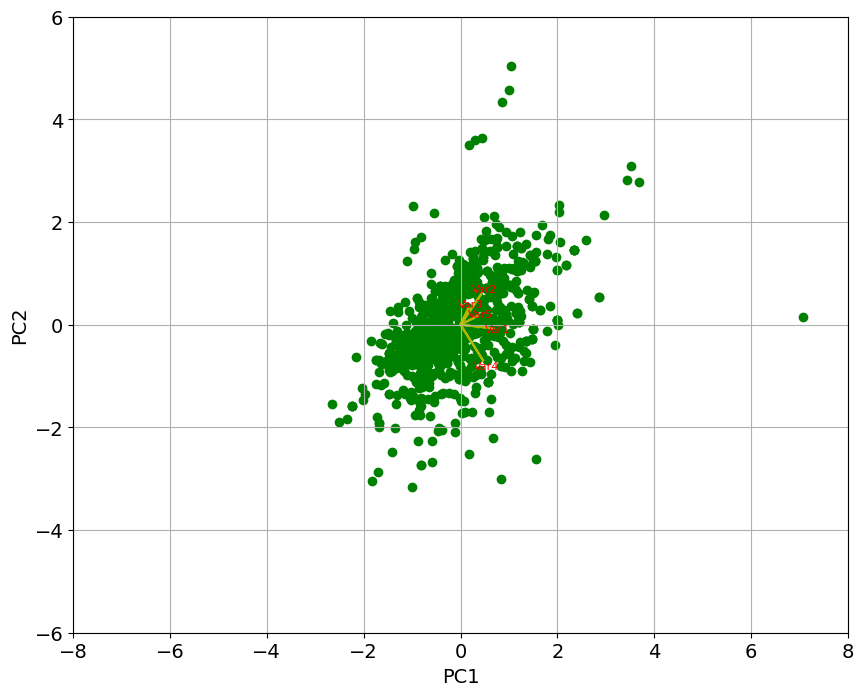

In [74]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_std1[:,0:2], np.transpose(pca.components_[0:2, :]), y='w')
plt.show()

We can again verify visually that a) the variance is maximized and b) that feature 1, 2 and 4 are the most important for PC1. Similarly, feature 2 and then 4 are the most important for PC2.

Furthermore, arrows (variables/features) that point into the same direction indicate correlation between the variables that they represent whereas, the arrows heading in opposite directions indicate a contrast between the variables they represent.

Verify the above using code:

In [73]:
# Var 1and Var 2 are very positively correlated
np.corrcoef(X_std1[:,0], X_std1[:,1])[1,0]

0.5196677129034458

In [72]:
# Var 1 and Var 4 are extremely positively correlated
np.corrcoef(X_std1[:,0], X_std1[:,3])[1,0]

0.6206992784042987

In [71]:
# Var 1 and Var 5 are positively correlated
np.corrcoef(X_std1[:,0], X_std1[:,4])[1,0]

0.24525752343034601